## Set up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, categorical_input_columns, evaluate_training_size_dependence, pipelines, reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, plot_confusion_matrix, view_as_exponential, view_decision_tree_julian, view_linear_model_richard

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
# from source import load_avenio_files
# from transform import clean_mutation_columns

# allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]
# # Load data from spreadsheet and SPSS files.
# patient_mutations, patient_no_mutations, phenotypes = load_avenio_files(
#     spread_sheet_filename='2019-08-27_PLASMA_SOMATIC_Results_Groningen.xlsx', spss_filename = "phenotypes_20191018.sav"
# )

# # Vocabulary is the entire dataset, not only training set. Otherwise we run
# # into problems during inference.
# gene_vocabulary = patient_mutations["Gene"].unique()

# # Convert particular columns to numbers and drop rows with missing data.
# clean_patient_mutations, dirty_patient_mutations = clean_mutation_columns(
#     patient_mutations, columns_to_number=allele_columns
# )


In [4]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(dirty_patient_mutations)

In [5]:
load_process_and_store_spreadsheets(
    spread_sheet_filename='2019-08-27_PLASMA_SOMATIC_Results_Groningen.xlsx', 
    transformation=harmonic_mean,
)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Overall survival and progression free survival
### Population results
To first get an idea of the overall factors, we have a brief look at the data as a whole.

In [6]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

First calculate distribution of the overall survival (OS) and progression free survival (PFS) and the cumulative distribution.

In [7]:
# Calculate the distribution and cumulative distribution for:
# 1) overall survival.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)
# 2) progression free survival.
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'], hist_bins=10, cum_hist_bins=15)

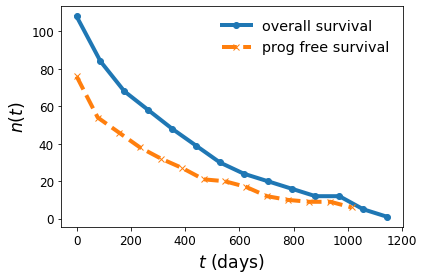

In [8]:
plt.figure()
plt.plot(t_OS_cum, p_OS_cum, '-o', label='overall survival')
plt.plot(t_PFS_cum, p_PFS_cum, '--x', label='prog free survival')
plt.xlabel('$t$ (days)')
plt.ylabel('$n(t)$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


(-22.88, 1166.88)

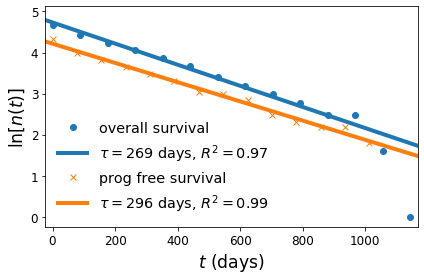

In [9]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers, markers=['o', '-'], label='overall survival')
view_as_exponential(t_PFS_cum, p_PFS_cum, markers=['x', '-'], label='prog free survival')
plt.gca()
dt = t_OS_cum[-1] - t_OS_cum[0]
plt.xlim([t_OS_cum[0] - 0.02*dt, t_OS_cum[-1] + 0.02*dt])

### Phenotype differences
Two exponentials form approximately an exponential
$$
\frac{n_1}{N} e^{-\alpha_1 t} + \frac{n_2}{N} e^{-\alpha_2 t} \approx \exp\left(-\frac{n_1}{N}\alpha_1 t - \frac{n_2}{N}\alpha_2t \right) \equiv \exp(-\alpha t) ,
$$
with $N=n_1 + n_2$, when $n_2(\alpha_1 - \alpha_2)/N t \ll 1$ for relevant $t$. That is, our new $\alpha$ is a weighted average of the individual ones.

In [10]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [11]:
from fit import fit_categorical_survival

X['gender']
df = fit_categorical_survival(X['gender'], y['OS_days'])
df

,tau,sigma_t,n,r
all,219.808,315.197,138,-0.932411
female,265.715,301.155,60,-0.995611
male,233.673,322.8,78,-0.949479


In [12]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)

In [13]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              female-male                                             32.04   
stage               4-3                                                     50.24   
therapyline         2-3+1+0+4                                               67.28   
smokingstatus       smoker-previous                                        115.51   
                    smoker-unknown+non smoker                              166.65   
                    previous-unknown+non smoker                             51.14   
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...      19.38   
histology_grouped   adeno-squamous                                           1.02   
                    adeno-other                                             65.97   
                    squamous-other                                          64.95   
lymfmeta            metastasis present-no metastasis present               113.12   
brainmeta           no metastasis present-metastasis present                63.16   
adrenalmeta         no metastasis present-metastasis present                44.89   
livermeta           no metastasis present-metastasis present                14.69   
lungmeta            metastasis present-no metastasis present                20.53   
skeletonmeta        no metastasis present-metastasis present                25.75   

                                                                        signal to noise  
category            item                                                                 
gender              female-male                                                    0.10  
stage               4-3                                                            0.16  
therapyline         2-3+1+0+4                                                      0.21  
smokingstatus       smoker-previous                                                0.37  
                    smoker-unknown+non smoker                                      0.53  
                    previous-unknown+non smoker                                    0.16  
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...             0.06  
histology_grouped   adeno-squamous                                                 0.00  
                    adeno-other                                                    0.21  
                    squamous-other                                                 0.21  
lymfmeta            metastasis present-no metastasis present                       0.36  
brainmeta           no metastasis present-metastasis present                       0.20  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.05  
lungmeta            metastasis present-no metastasis present                       0.07  
skeletonmeta        no metastasis present-metastasis present                       0.08

In [14]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              female-male                                             32.04   
stage               4-3                                                     50.24   
therapyline         2-3+1+0+4                                               67.28   
smokingstatus       smoker-previous                                        115.51   
                    smoker-unknown+non smoker                              166.65   
                    previous-unknown+non smoker                             51.14   
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...      19.38   
histology_grouped   adeno-squamous                                           1.02   
                    adeno-other                                             65.97   
                    squamous-other                                          64.95   
lymfmeta            metastasis present-no metastasis present               113.12   
brainmeta           no metastasis present-metastasis present                63.16   
adrenalmeta         no metastasis present-metastasis present                44.89   
livermeta           no metastasis present-metastasis present                14.69   
lungmeta            metastasis present-no metastasis present                20.53   
skeletonmeta        no metastasis present-metastasis present                25.75   

                                                                        signal to noise  
category            item                                                                 
gender              female-male                                                    0.10  
stage               4-3                                                            0.16  
therapyline         2-3+1+0+4                                                      0.21  
smokingstatus       smoker-previous                                                0.37  
                    smoker-unknown+non smoker                                      0.53  
                    previous-unknown+non smoker                                    0.16  
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...             0.06  
histology_grouped   adeno-squamous                                                 0.00  
                    adeno-other                                                    0.21  
                    squamous-other                                                 0.21  
lymfmeta            metastasis present-no metastasis present                       0.36  
brainmeta           no metastasis present-metastasis present                       0.20  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.05  
lungmeta            metastasis present-no metastasis present                       0.07  
skeletonmeta        no metastasis present-metastasis present                       0.08

In [15]:
effect_summary = categorical_signal_summary(X, y['PFS_days'], categorical_input_columns)
effect_summary

delta tau  \
category            item                                                              
gender              female-male                                           47.389483   
stage               4-3                                                  109.175677   
therapyline         2-3+1+0+4                                             93.006540   
smokingstatus       smoker-previous                                       62.242898   
                    smoker-unknown+non smoker                             45.421598   
                    previous-unknown+non smoker                           16.821300   
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...    47.646255   
histology_grouped   adeno-squamous                                        99.600241   
                    adeno-other                                          914.323888   
                    squamous-other                                      1013.924130   
lymfmeta            metastasis present-no metastasis present              33.857541   
brainmeta           no metastasis present-metastasis present             170.811851   
adrenalmeta         no metastasis present-metastasis present              42.998257   
livermeta           no metastasis present-metastasis present             170.055971   
lungmeta            metastasis present-no metastasis present              41.962468   
skeletonmeta        no metastasis present-metastasis present             101.817219   

                                                                        signal to noise  
category            item                                                                 
gender              female-male                                                0.162301  
stage               4-3                                                        0.373908  
therapyline         2-3+1+0+4                                                  0.318532  
smokingstatus       smoker-previous                                            0.213172  
                    smoker-unknown+non smoker                                  0.155561  
                    previous-unknown+non smoker                                0.057610  
Systemischetherapie nivolumab-pembrolizumab+ipi-novu+atezolizumab+d...         0.163180  
histology_grouped   adeno-squamous                                             0.341114  
                    adeno-other                                                3.131406  
                    squamous-other                                             3.472520  
lymfmeta            metastasis present-no metastasis present                   0.115956  
brainmeta           no metastasis present-metastasis present                   0.585002  
adrenalmeta         no metastasis present-metastasis present                   0.147262  
livermeta           no metastasis present-metastasis present                   0.582413  
lungmeta            metastasis present-no metastasis present                   0.143714  
skeletonmeta        no metastasis present-metastasis present                   0.348707

### Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
A model should at least be able to out perform the following mean squared error:
$$
\Delta e^2 = \frac{1}{N}\left(n_1 \frac{{\tau_1}^2}{\ln^2 2} + n_2 \frac{{\tau_2}^2}{\ln^2 2} \right) \, .
$$

Using the value above $\tau =258$ days gives a variance of

### Tuning the pipeline
We use a variety of different pipelines and different algorithms to try to squeeze as much signal from the data as possible. Let us focus on the overall survival first.

In [16]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5

Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

#### overall survival

In [17]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,403.509837,405.455441,413.950281,387.028277
RandomForestRegressor,381.724451,364.003071,360.882153,363.088667
GradientBoostingRegressor,359.071486,377.438139,378.857833,363.231731
KNeighborsRegressor,413.959788,345.698798,390.669558,370.720952
ElasticNet,360.198277,372.693432,345.780286,365.560017
LinearRegression,351.399398,384.102311,13939.112725,350.269606
SVR,402.552995,401.429345,402.553726,401.987704
DummyRegressor,402.595818,402.595818,402.595818,402.595818


### Training size dependence

In [18]:
p_Lev = pipelines['LinearRegression']['Lev']
m, err = evaluate_training_size_dependence(p_Lev, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse)

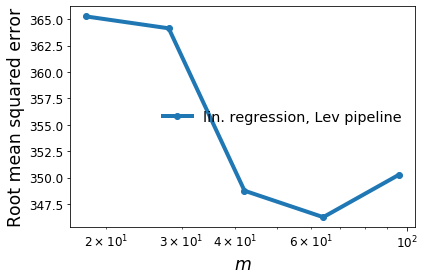

In [19]:
plt.ylabel('Root mean squared error')
plt.xlabel('$m$')
plt.semilogx(m ,err, 'o-', label='lin. regression, Lev pipeline')
plt.legend(frameon=False)

The data indicates that the linear regression model with the `Lev` pipeline (which combines the `Richard` and `Julian` pipelines) gives the best results.

#### progression free survival

In [20]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,403.509837,405.455441,413.950281,387.028277
RandomForestRegressor,381.724451,364.003071,360.882153,363.088667
GradientBoostingRegressor,359.071486,377.438139,378.857833,363.231731
KNeighborsRegressor,413.959788,345.698798,390.669558,370.720952
ElasticNet,360.198277,372.693432,345.780286,365.560017
LinearRegression,351.399398,384.102311,13939.112725,350.269606
SVR,402.552995,401.429345,402.553726,401.987704
DummyRegressor,402.595818,402.595818,402.595818,402.595818


- $\Delta \tau$ 
- Calculation of $\Delta \tau$ for various phenotypes.
- Tuning of pipeline.
- Somatic vs all
- Hybrid model best performance.
### Decypher effects of input features

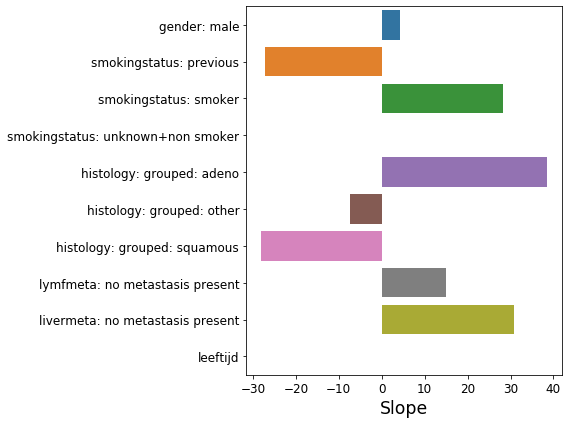

In [21]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(pipeline=p_richard)

[-5836.80887201   819.94065255 -7785.81224563 -1512.23328967
  6378.61337233  1301.31312292    -8.79675368 -4755.79274776
 -2053.83651601  2116.51067112 -2867.81425051  6200.46655143
 -1807.04067169  3550.34519632]


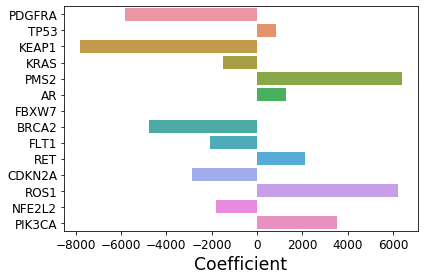

In [22]:
p_julian = pipelines['LinearRegression']['Julian']
classifier = p_julian.steps[-1][1]
column_names = p_julian.steps[-2][1].columns_to_keep_
print(classifier.coef_)
with sns.plotting_context(font_scale=1.5):
#     plt.figure(figsize=(14, 6))
    plt.xlabel(r"Coefficient")
    sns.barplot(x=classifier.coef_, y=column_names, label="large")
    plt.tight_layout()


The sheer size of the coefficients are related to the size of the input variables (which are calculated using the harmonic mean). But the positive sign of `TP53` indicates that the presence of this variable is indicative for prolonger survival.

## Classification
**Goal**: Identify patients that don't respond.

These patients we don't have to treat.

In [23]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'

We want to:
- Maximize our predictive capacity, we do this by maximizing the area under receiver operating curve.
- And at the same time, we don't want to deny patients treatment that could potentially benefit.

The latter statement translates to a minimisation of false positives (predicted is non-responder \[=positive\], but is actually a responder \[=false\]).

We use the area under the receiver operating curve $r_{\mathrm{TP}}(r_{\mathrm{FP}})$:
$$
    A = \int_0^1 r_{\mathrm{TP}}(r_{\mathrm{FP}}) \, \mathrm{d}r_{\mathrm{FP}} \, .
$$
to quantify the models predictive capacity.

In [24]:
# We evaluate the predictive capacity using AUC of ROC.
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [25]:
ps_class = build_classifier_pipelines()

In [26]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=auc,
)
print(b.round(2).to_latex())

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


\begin{tabular}{lrrrr}
\toprule
{} &  Richard\_test &  Julian\_test &  Freeman\_test &  Lev\_test \\
\midrule
DecisionTreeClassifier     &          0.40 &         0.57 &          0.49 &      0.41 \\
RandomForestClassifier     &          0.44 &         0.65 &          0.68 &      0.54 \\
GaussianNB                 &          0.52 &         0.58 &          0.46 &      0.57 \\
GradientBoostingClassifier &          0.45 &         0.50 &          0.56 &      0.50 \\
KNeighborsClassifier       &          0.42 &         0.42 &          0.40 &      0.48 \\
LogisticRegression         &          0.48 &         0.50 &          0.56 &      0.48 \\
SVC                        &          0.50 &         0.50 &          0.50 &      0.50 \\
DummyClassifier            &          0.50 &         0.50 &          0.50 &      0.50 \\
\bottomrule
\end{tabular}



It seems that our `Julian` pipeline using a DecisionTreeClassifier is the overall winner. Let us take a more in depth look at the confusion matrix.

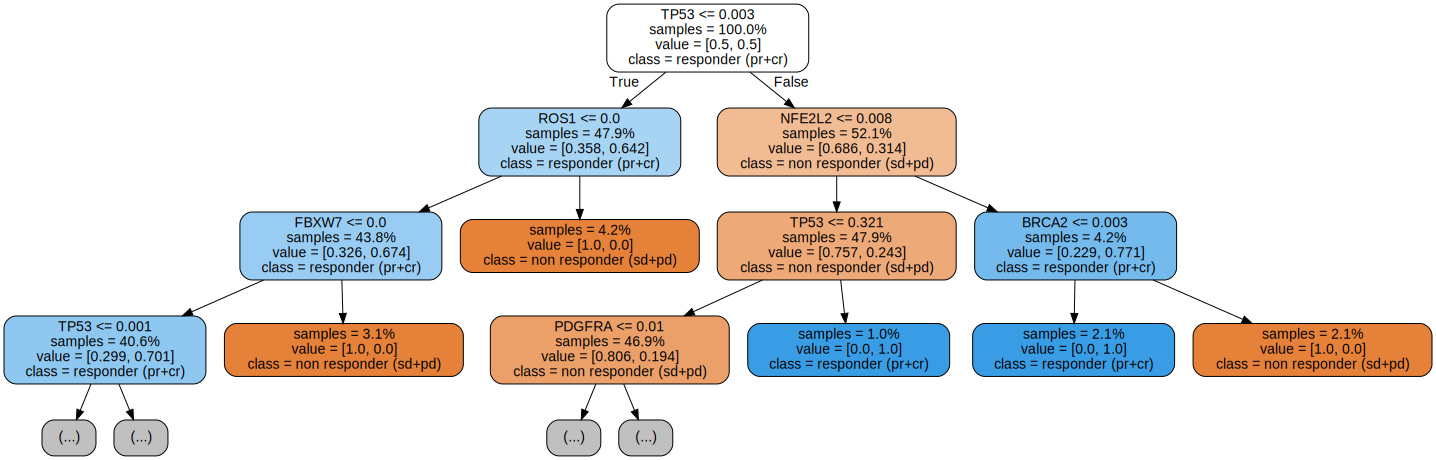

In [27]:
p_win = ps_class['DecisionTreeClassifier']['Julian']
view_decision_tree_julian(p_win, save_to='classifier_tree.png')

Confusion matrix, without normalization
[[13 16]
 [ 4  9]]


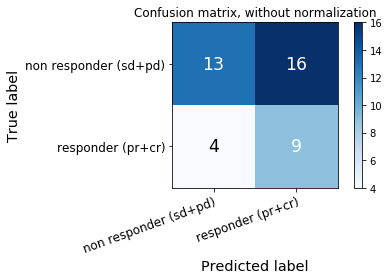

In [28]:
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

In [29]:
pos_label_index = np.argwhere(p_win.classes_ == pos_label)[0][0]
p = p_win.predict_proba(X_test)[:, pos_label_index]

fpr, tpr, thresholds = roc_curve(y_test_resp.values, p, pos_label=pos_label)

Text(0, 0.5, '$r_{\\mathrm{TP}}$')

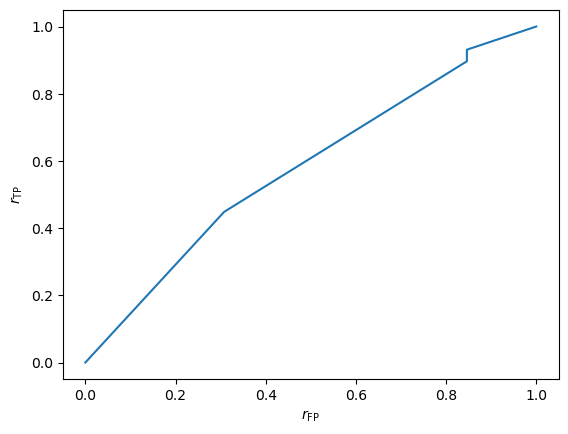

In [30]:
plt.plot(fpr, tpr)
plt.xlabel(r'$r_{\mathrm{FP}}$')
plt.ylabel(r'$r_{\mathrm{TP}}$')

In [31]:
print(type(y_test_resp.values))
print(type(p_win.predict(X_test)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Training size dependence.

In [32]:
p_Julian = ps_class['DecisionTreeClassifier']['Julian']
m, err = evaluate_training_size_dependence(p_Julian, X_train, y_train_resp, X_test, y_test_resp, metric=auc)

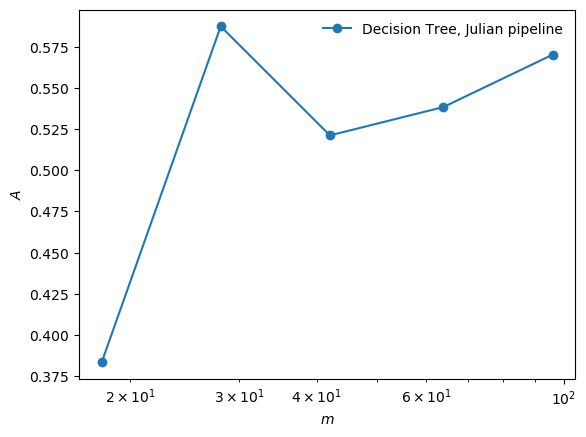

In [33]:
plt.semilogx(m ,err, 'o-', label='Decision Tree, Julian pipeline')
plt.ylabel('$A$')
plt.xlabel('$m$')
plt.legend(frameon=False)